In [17]:
import open3d as o3d
import nrrd
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from skimage.transform import rescale, resize, downscale_local_mean
from pydicom.data import get_testdata_files
from collections import Counter
from scipy.ndimage import zoom
pat_dir='C:/Users/56-000M100-32/Arthur/datasets_graz/graz/Mandibular_Datasets/'
subjects= os.listdir(pat_dir)

In [18]:
def o3d_visualize(pcs,colors): #visualization
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.array(pcs))
    pcd.colors = o3d.utility.Vector3dVector(np.array(colors))
    
    o3d.visualization.draw_geometries([pcd],
                                  zoom=0.3412,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[64, 64, 64],
                                  up=[-0.0694, -0.9768, 0.2024])

In [19]:
def o3d_save(pcs,colors,path): #save a scene
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.array(pcs))
    pcd.colors = o3d.utility.Vector3dVector(np.array(colors))
    
    o3d.io.write_point_cloud(path, pcd)

In [20]:
def o3d_load(path): #load a scene
    pcd_load = o3d.io.read_point_cloud(path)
    return pcd_load

In [21]:
def v_to_pc(arr,z,count,pcs,colors,threshold): #voxel to pointcloud
    for y,row in enumerate(arr):
        for x,col in enumerate(row):
            if col >=threshold :
                pcs.append([x,y,z])
                colors.append(col)

In [22]:
def get_threshold(old_threshold,old_info,new_info):
    
    #_info = [max,mean,min,std]
    factor=(old_threshold-old_info[1])/old_info[3]
    new_threshold=new_info[1]+new_info[3]*factor  
    
    return new_threshold

In [23]:
def get_pcs(new_threshold,cube): #generate validated point clouds and colors
    count=0
    pcs=[]
    colors=[]
    for z,ds in enumerate(cube):
        v_to_pc(ds,z,count,pcs,colors,new_threshold)
        #print(pcs[-100:])

    return pcs,colors

In [24]:
def get_3d(sub): #get whole cube 3d array 
    filename=pat_dir+sub
    readdata, header = nrrd.read(filename)
    print(readdata.shape)
    readdata = np.einsum('ijk->kji', readdata) #x,y,z -> z,y,x
    print(readdata.shape)
    return readdata

In [25]:
def filter_eyebox(cube): #filter out eyebox, maybe just filter out 1024?
    colors= cube.flatten()
    eyebox_color = Counter(colors).most_common()
    for i in eyebox_color:
        if i[0]>0:
            print(i)
            break
    target = i[0]
    for i,img in enumerate(cube):
        for j,row in enumerate(img):
            for k,c in enumerate(row):
                if c==target:
                    cube[i][j][k]=-1000
    return cube

In [26]:
def fn(sub,input_size,old_threshold): #generate pointclouds and colors
    
    #step1: get 3d array
    cube = get_3d(sub)   #z,y,x
    
    plt.imshow(cube[0])  #yaxis=y,xaxis=x
    plt.scatter(x=0,y=128,color='r',s=1) 
    plt.show()
    #step2: filter out eyebox
    cube = filter_eyebox(cube) #z,y,x
    
    #step3: resize
    ratio = (input_size/cube.shape[0],input_size/cube.shape[1],input_size/cube.shape[2])
    old_info = [cube.max(),cube.mean(),cube.min(),cube.std()]
    print('old: ', old_info)

    cube = zoom(cube, ratio)  #z,y,x
    new_info = [cube.max(),cube.mean(),cube.min(),cube.std()]
    print('new: ', new_info)
    print(cube.shape)
    
    #step3: derive threshold for bone
    new_threshold  = get_threshold(old_threshold,old_info,new_info)
    print(new_threshold, old_threshold )  
    
    #step4: get all points whose greyscale are greater than new_threshold
    pcs, colors = get_pcs(new_threshold,cube) #voxel(z,y,x) -> pcs(x,y,z)
   
    
    
    return np.array(pcs),np.array(colors)

In [27]:
def clustering(pcs,colors,MAX_DISTANCE=25,QUEUE_MAX_LENGTH=300): #self-made over-segmentation, further add colors in formula
    seg=[]
    count=0
    seg_idx=0
    anchors=[]
    anchor_x=-100
    anchor_y=-100
    anchor_z=-100
    
    
    for index,pc in enumerate(pcs):
        
        #initial
        x,y,z=pc
        target_anchor=None
        near_an_anchor=False
        min_distance = 100
        
        #search closet anchor point
        for pop in anchors:
            p1=np.array(pc)
            p2=np.array(pop[:-1])
            squared_dist = np.sum((p1-p2)**2, axis=0)# + abs(colors[index][0]-colors[pop[3]][0])*60**2
            #print(squared_dist, abs(colors[index][0]-colors[pop[3]][0])*60**2)
            if squared_dist<=MAX_DISTANCE and  squared_dist < min_distance :
                near_an_anchor=True
                target_anchor=pop[3]
                min_distance = squared_dist
        
        #update seg[] or seg[] & anchor[]
        if  near_an_anchor:
            #print('same')
            seg.append(target_anchor)
        else:
            #print('add new anchor')
            if len(anchors)>QUEUE_MAX_LENGTH:
                _null=anchors.pop(0)
            anchor_x=x
            anchor_y=y
            anchor_z=z
            seg_idx=index
            seg.append(index)
            anchors.append([anchor_x,anchor_y,anchor_z,seg_idx])
            count=count+1
        
        #print(z,target_anchor,len(anchors),end=" ")
        


    print('cluster count: ',count)
    print(len(seg))
    return seg

(512, 512, 294)
(294, 512, 512)


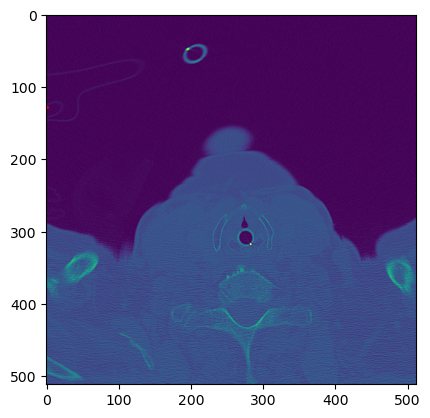

(1024, 2983914)
old:  [3071, -545.3795647004835, -1024, 563.3746540620233]
new:  [3299, -551.6567430496216, -1831, 558.7240427453928]
(128, 128, 128)
385.91879129485073 400
(87542, 3)
cluster count:  1780
87542
(512, 512, 217)
(217, 512, 512)


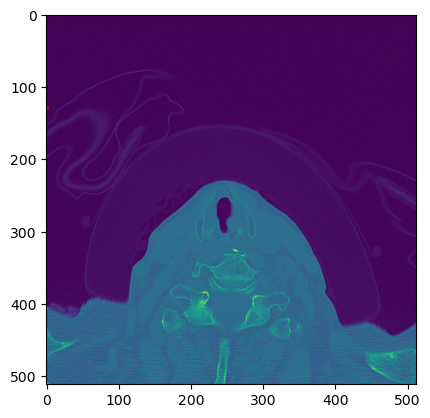

(1024, 7445801)
old:  [3022, -591.279463684504, -1024, 541.665821345496]
new:  [2422, -594.0592012405396, -1304, 537.3916369433791]
(128, 128, 128)
389.3982602890294 400
(69485, 3)
cluster count:  1526
69485
(512, 512, 154)
(154, 512, 512)


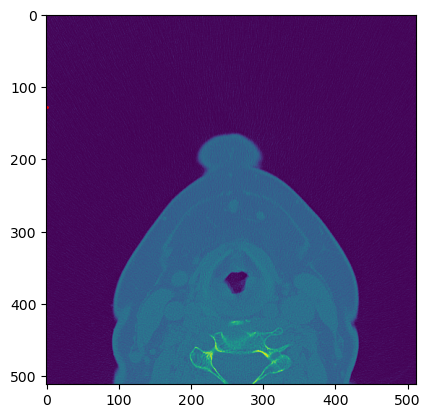

(1024, 2381748)
old:  [3059, -523.4973710790857, -1024, 540.6328288387075]
new:  [2899, -525.8165917396545, -1575, 539.654661985189]
(128, 128, 128)
396.0098957572385 400
(60026, 3)
cluster count:  2153
60026
(512, 512, 136)
(136, 512, 512)


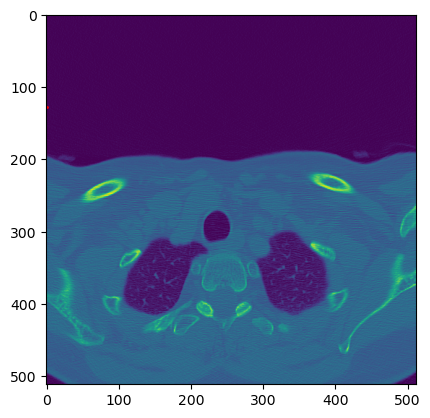

(1024, 1025422)
old:  [2690, -576.4738747933332, -1024, 557.2302048697254]
new:  [2658, -579.076708316803, -1335, 555.6367476411132]
(128, 128, 128)
394.60483874421664 400
(85654, 3)
cluster count:  1731
85654
(512, 512, 141)
(141, 512, 512)


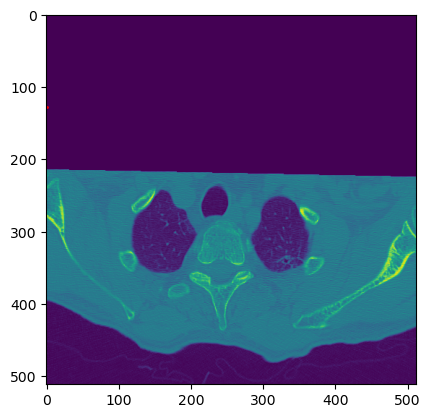

(1024, 660560)
old:  [2314, -636.2853149251735, -1024, 515.4419004471199]
new:  [2235, -639.9565138816833, -1527, 512.874113395531]
(128, 128, 128)
391.16631811164393 400
(58514, 3)
cluster count:  1713
58514
(512, 512, 232)
(232, 512, 512)


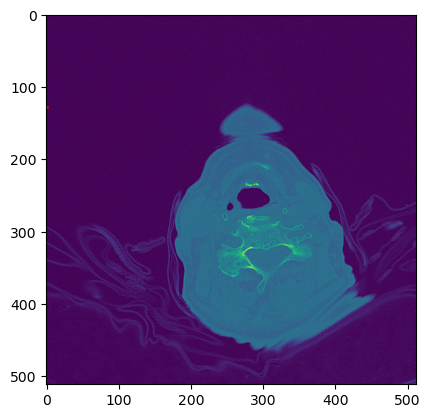

(1024, 1388915)
old:  [3033, -667.887166138353, -1024, 514.6073550483566]
new:  [2687, -673.5716848373413, -1503, 509.8693231290144]
(128, 128, 128)
384.4833570031692 400
(59887, 3)
cluster count:  1283
59887
(512, 512, 168)
(168, 512, 512)


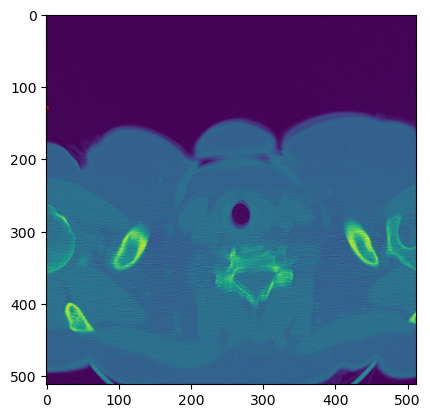

(1024, 1139514)
old:  [2459, -594.5490072341192, -1024, 577.9574067990461]
new:  [2388, -599.0115866661072, -1376, 575.3814675103977]
(128, 128, 128)
391.10474467860786 400
(91113, 3)
cluster count:  1787
91113
(512, 512, 200)
(200, 512, 512)


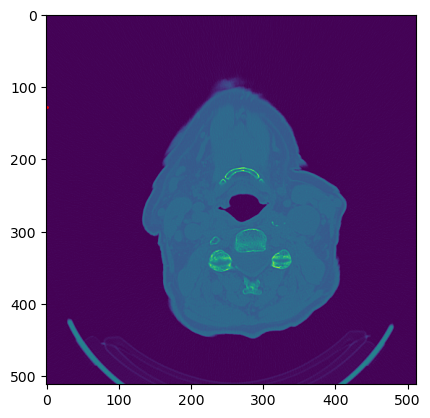

(1024, 1673041)
old:  [2956, -613.9376432609558, -1024, 597.0437906128267]
new:  [2636, -617.8130521774292, -1461, 594.5268154583885]
(128, 128, 128)
391.85010419267735 400
(101302, 3)
cluster count:  2218
101302
(512, 512, 110)
(110, 512, 512)


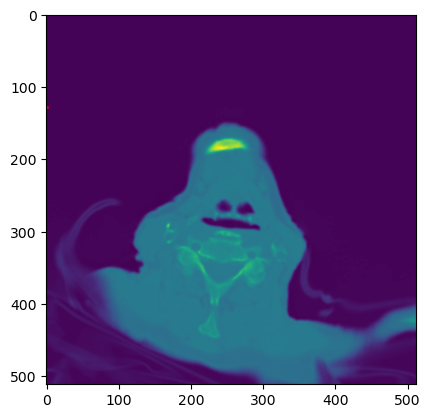

(1024, 890573)
old:  [2300, -669.5519403631037, -1024, 531.8294275936795]
new:  [2286, -671.7189722061157, -1178, 529.9776740932033]
(128, 128, 128)
394.1089422818691 400
(75899, 3)
cluster count:  1278
75899
(512, 512, 298)
(298, 512, 512)


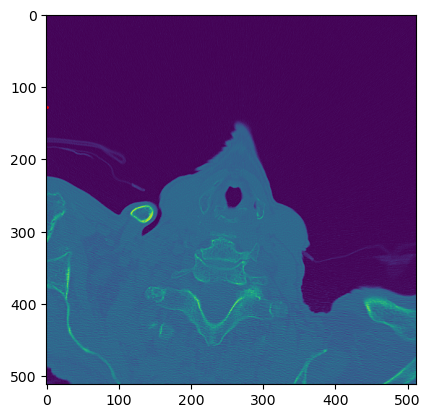

(1024, 2218785)
old:  [2669, -620.7358123216053, -1024, 541.6438062556193]
new:  [2312, -622.8967003822327, -1289, 539.1627544795804]
(128, 128, 128)
393.1635329504163 400
(86795, 3)
cluster count:  1810
86795


In [28]:
for sub in subjects:
#sub = subjects[3]
    #step1: preprocess pointclouds and colors
    pcs,colors = fn(sub,input_size=128,old_threshold = 400)
    
    #step2: linear scale colors to 0~1 and save in .ply
    '''
    colors=preprocessing.minmax_scale(colors, feature_range=(0,1))
    tmp=[]
    for i in colors:
        tmp.append([i,i,i])
 
    colors=np.array(tmp)
    
    #o3d_save(pcs,colors,'./temp_thd400_'+sub+'.ply')
    '''
    print(pcs.shape)
    
    #step3: clustering
    seg =clustering(pcs,colors)
    
    #step4: linear scale seg to 0~1 and save in .ply
    c=preprocessing.minmax_scale(seg, feature_range=(0,1))
    tmp=[]
    for i in c:
        tmp.append([i,i,i])  


    writepath = './0825_sz128_dist25_thd400_'+sub[:-5]
    o3d_save(pcs,tmp,writepath+'.ply') 
    
    #step4.5: make sure data in correct form
    seg =np.array(seg)
    colors =np.array(colors)
    pcs =np.array(pcs)
    
    #step5: store data in txt
    txt_path=writepath+'.txt'
    f =open(txt_path,'w')
    for i,line in enumerate(pcs):
        f.write(str(line[0])+','+str(line[1])+','+str(line[2])+','+str(colors[i])+','+str(seg[i])+',-100\n')
    f.close()
    
    #a scene done

In [29]:
#.ply visualization
pcd_load=o3d_load(writepath+'.ply')
o3d_visualize(pcd_load.points,pcd_load.colors)

In [30]:
#.txt verification
r=open(txt_path,'r')
a=np.genfromtxt(r, delimiter=",", usemask=True)
print(a.shape)
for i in a:
    print(i)

(86795, 6)
[0.0 62.0 0.0 435.0 0.0 -100.0]
[3.0 62.0 0.0 1023.0 0.0 -100.0]
[73.0 64.0 0.0 426.0 2.0 -100.0]
[33.0 66.0 0.0 1546.0 3.0 -100.0]
[34.0 66.0 0.0 1550.0 3.0 -100.0]
[35.0 66.0 0.0 1414.0 3.0 -100.0]
[36.0 66.0 0.0 405.0 3.0 -100.0]
[30.0 67.0 0.0 610.0 3.0 -100.0]
[31.0 67.0 0.0 1358.0 3.0 -100.0]
[34.0 67.0 0.0 478.0 3.0 -100.0]
[36.0 67.0 0.0 1246.0 3.0 -100.0]
[6.0 68.0 0.0 953.0 11.0 -100.0]
[29.0 68.0 0.0 434.0 3.0 -100.0]
[30.0 68.0 0.0 483.0 3.0 -100.0]
[36.0 68.0 0.0 492.0 3.0 -100.0]
[4.0 69.0 0.0 697.0 11.0 -100.0]
[5.0 69.0 0.0 399.0 11.0 -100.0]
[29.0 69.0 0.0 712.0 3.0 -100.0]
[36.0 69.0 0.0 1742.0 3.0 -100.0]
[3.0 70.0 0.0 989.0 11.0 -100.0]
[4.0 70.0 0.0 545.0 11.0 -100.0]
[30.0 70.0 0.0 540.0 3.0 -100.0]
[31.0 70.0 0.0 1384.0 3.0 -100.0]
[35.0 70.0 0.0 1568.0 3.0 -100.0]
[36.0 70.0 0.0 1649.0 3.0 -100.0]
[74.0 70.0 0.0 997.0 25.0 -100.0]
[2.0 71.0 0.0 1070.0 11.0 -100.0]
[32.0 71.0 0.0 1254.0 27.0 -100.0]
[33.0 71.0 0.0 1447.0 27.0 -100.0]
[34.0 71.0 0.0 113

[68.0 70.0 6.0 536.0 2071.0 -100.0]
[27.0 71.0 6.0 1393.0 1747.0 -100.0]
[34.0 71.0 6.0 1836.0 1422.0 -100.0]
[58.0 71.0 6.0 475.0 1434.0 -100.0]
[59.0 71.0 6.0 627.0 1434.0 -100.0]
[60.0 71.0 6.0 434.0 1434.0 -100.0]
[10.0 72.0 6.0 463.0 1446.0 -100.0]
[28.0 72.0 6.0 1122.0 1747.0 -100.0]
[33.0 72.0 6.0 791.0 1747.0 -100.0]
[34.0 72.0 6.0 1037.0 1422.0 -100.0]
[49.0 72.0 6.0 453.0 2076.0 -100.0]
[64.0 72.0 6.0 607.0 2071.0 -100.0]
[65.0 72.0 6.0 768.0 2071.0 -100.0]
[66.0 72.0 6.0 434.0 2071.0 -100.0]
[67.0 72.0 6.0 894.0 2071.0 -100.0]
[29.0 73.0 6.0 1187.0 1747.0 -100.0]
[33.0 73.0 6.0 1742.0 1747.0 -100.0]
[56.0 73.0 6.0 424.0 1434.0 -100.0]
[67.0 73.0 6.0 566.0 1759.0 -100.0]
[71.0 73.0 6.0 732.0 1759.0 -100.0]
[29.0 74.0 6.0 456.0 1747.0 -100.0]
[30.0 74.0 6.0 1208.0 1747.0 -100.0]
[31.0 74.0 6.0 1309.0 1747.0 -100.0]
[32.0 74.0 6.0 1588.0 1747.0 -100.0]
[55.0 74.0 6.0 463.0 1454.0 -100.0]
[67.0 74.0 6.0 582.0 1759.0 -100.0]
[70.0 74.0 6.0 487.0 1759.0 -100.0]
[10.0 75.0 6.0 532.

[11.0 72.0 10.0 1281.0 3521.0 -100.0]
[26.0 72.0 10.0 1619.0 3498.0 -100.0]
[27.0 72.0 10.0 428.0 3498.0 -100.0]
[32.0 72.0 10.0 1117.0 3498.0 -100.0]
[57.0 72.0 10.0 495.0 2984.0 -100.0]
[64.0 72.0 10.0 432.0 2526.0 -100.0]
[65.0 72.0 10.0 634.0 2526.0 -100.0]
[67.0 72.0 10.0 399.0 2985.0 -100.0]
[68.0 72.0 10.0 610.0 2985.0 -100.0]
[11.0 73.0 10.0 1034.0 3521.0 -100.0]
[16.0 73.0 10.0 394.0 4087.0 -100.0]
[21.0 73.0 10.0 1418.0 2998.0 -100.0]
[26.0 73.0 10.0 991.0 3548.0 -100.0]
[32.0 73.0 10.0 850.0 3498.0 -100.0]
[54.0 73.0 10.0 624.0 3019.0 -100.0]
[59.0 73.0 10.0 474.0 4092.0 -100.0]
[60.0 73.0 10.0 585.0 4092.0 -100.0]
[67.0 73.0 10.0 484.0 2985.0 -100.0]
[68.0 73.0 10.0 435.0 2985.0 -100.0]
[69.0 73.0 10.0 1039.0 2985.0 -100.0]
[17.0 74.0 10.0 817.0 4087.0 -100.0]
[26.0 74.0 10.0 1165.0 3548.0 -100.0]
[32.0 74.0 10.0 1358.0 3548.0 -100.0]
[53.0 74.0 10.0 678.0 3019.0 -100.0]
[63.0 74.0 10.0 470.0 2526.0 -100.0]
[64.0 74.0 10.0 663.0 2526.0 -100.0]
[66.0 74.0 10.0 439.0 3569.0 -

[65.0 87.0 13.0 1442.0 4298.0 -100.0]
[66.0 87.0 13.0 524.0 4298.0 -100.0]
[3.0 88.0 13.0 417.0 4291.0 -100.0]
[10.0 88.0 13.0 448.0 3722.0 -100.0]
[11.0 88.0 13.0 425.0 5520.0 -100.0]
[22.0 88.0 13.0 405.0 6045.0 -100.0]
[54.0 88.0 13.0 420.0 4326.0 -100.0]
[55.0 88.0 13.0 645.0 4326.0 -100.0]
[56.0 88.0 13.0 398.0 4326.0 -100.0]
[64.0 88.0 13.0 747.0 4298.0 -100.0]
[55.0 89.0 13.0 435.0 4326.0 -100.0]
[57.0 89.0 13.0 593.0 4326.0 -100.0]
[58.0 89.0 13.0 567.0 6088.0 -100.0]
[63.0 89.0 13.0 426.0 4298.0 -100.0]
[65.0 89.0 13.0 510.0 4298.0 -100.0]
[55.0 90.0 13.0 493.0 4326.0 -100.0]
[57.0 90.0 13.0 445.0 6088.0 -100.0]
[64.0 90.0 13.0 452.0 4969.0 -100.0]
[65.0 90.0 13.0 655.0 4298.0 -100.0]
[56.0 91.0 13.0 894.0 6088.0 -100.0]
[57.0 91.0 13.0 647.0 6088.0 -100.0]
[63.0 91.0 13.0 550.0 4969.0 -100.0]
[64.0 91.0 13.0 568.0 4969.0 -100.0]
[56.0 92.0 13.0 712.0 6088.0 -100.0]
[57.0 92.0 13.0 916.0 6088.0 -100.0]
[58.0 92.0 13.0 641.0 6088.0 -100.0]
[60.0 92.0 13.0 398.0 6088.0 -100.0]
[

[48.0 39.0 19.0 726.0 7776.0 -100.0]
[52.0 39.0 19.0 1767.0 7774.0 -100.0]
[53.0 39.0 19.0 1696.0 7774.0 -100.0]
[47.0 40.0 19.0 1642.0 7776.0 -100.0]
[48.0 40.0 19.0 716.0 7776.0 -100.0]
[50.0 40.0 19.0 1401.0 7776.0 -100.0]
[51.0 40.0 19.0 1830.0 7776.0 -100.0]
[52.0 40.0 19.0 563.0 7774.0 -100.0]
[47.0 41.0 19.0 1627.0 7776.0 -100.0]
[48.0 41.0 19.0 1256.0 7776.0 -100.0]
[49.0 41.0 19.0 1691.0 7776.0 -100.0]
[50.0 41.0 19.0 1451.0 7776.0 -100.0]
[86.0 41.0 19.0 552.0 7125.0 -100.0]
[87.0 41.0 19.0 1433.0 8089.0 -100.0]
[88.0 41.0 19.0 1827.0 8089.0 -100.0]
[47.0 42.0 19.0 845.0 7776.0 -100.0]
[48.0 42.0 19.0 1221.0 7776.0 -100.0]
[81.0 42.0 19.0 543.0 8093.0 -100.0]
[82.0 42.0 19.0 943.0 8093.0 -100.0]
[83.0 42.0 19.0 1416.0 8093.0 -100.0]
[84.0 42.0 19.0 1353.0 8093.0 -100.0]
[85.0 42.0 19.0 1225.0 8089.0 -100.0]
[86.0 42.0 19.0 1555.0 8089.0 -100.0]
[87.0 42.0 19.0 406.0 8089.0 -100.0]
[88.0 42.0 19.0 1991.0 8089.0 -100.0]
[89.0 42.0 19.0 2208.0 8089.0 -100.0]
[82.0 43.0 19.0 868.

[18.0 84.0 25.0 828.0 9801.0 -100.0]
[21.0 84.0 25.0 1749.0 9802.0 -100.0]
[56.0 84.0 25.0 494.0 9218.0 -100.0]
[58.0 84.0 25.0 487.0 9218.0 -100.0]
[0.0 90.0 25.0 651.0 10079.0 -100.0]
[1.0 91.0 25.0 539.0 10079.0 -100.0]
[2.0 91.0 25.0 403.0 10079.0 -100.0]
[3.0 92.0 25.0 554.0 10079.0 -100.0]
[4.0 92.0 25.0 781.0 10079.0 -100.0]
[5.0 92.0 25.0 804.0 10084.0 -100.0]
[4.0 93.0 25.0 526.0 10084.0 -100.0]
[5.0 93.0 25.0 513.0 10084.0 -100.0]
[6.0 93.0 25.0 517.0 10084.0 -100.0]
[7.0 94.0 25.0 688.0 10084.0 -100.0]
[3.0 95.0 25.0 442.0 10084.0 -100.0]
[0.0 96.0 25.0 781.0 9830.0 -100.0]
[1.0 96.0 25.0 519.0 9830.0 -100.0]
[2.0 96.0 25.0 413.0 9830.0 -100.0]
[3.0 96.0 25.0 454.0 9830.0 -100.0]
[4.0 96.0 25.0 402.0 9830.0 -100.0]
[8.0 96.0 25.0 901.0 9260.0 -100.0]
[0.0 97.0 25.0 428.0 9830.0 -100.0]
[2.0 97.0 25.0 732.0 9830.0 -100.0]
[3.0 97.0 25.0 804.0 9830.0 -100.0]
[2.0 98.0 25.0 543.0 9830.0 -100.0]
[3.0 98.0 25.0 1127.0 9830.0 -100.0]
[4.0 98.0 25.0 485.0 9830.0 -100.0]
[8.0 98.0 2

[77.0 68.0 35.0 405.0 11911.0 -100.0]
[55.0 69.0 35.0 627.0 11754.0 -100.0]
[56.0 69.0 35.0 750.0 11754.0 -100.0]
[57.0 69.0 35.0 420.0 11754.0 -100.0]
[58.0 69.0 35.0 1572.0 11754.0 -100.0]
[56.0 70.0 35.0 792.0 11952.0 -100.0]
[57.0 70.0 35.0 776.0 11952.0 -100.0]
[58.0 70.0 35.0 1146.0 11754.0 -100.0]
[56.0 71.0 35.0 596.0 11952.0 -100.0]
[57.0 71.0 35.0 853.0 11952.0 -100.0]
[58.0 71.0 35.0 883.0 11952.0 -100.0]
[57.0 72.0 35.0 694.0 11952.0 -100.0]
[58.0 72.0 35.0 1080.0 11952.0 -100.0]
[58.0 73.0 35.0 822.0 11952.0 -100.0]
[58.0 74.0 35.0 583.0 11952.0 -100.0]
[59.0 74.0 35.0 690.0 11952.0 -100.0]
[59.0 75.0 35.0 557.0 11952.0 -100.0]
[59.0 76.0 35.0 588.0 11422.0 -100.0]
[60.0 76.0 35.0 1012.0 11422.0 -100.0]
[61.0 77.0 35.0 899.0 11811.0 -100.0]
[62.0 77.0 35.0 1021.0 11811.0 -100.0]
[61.0 78.0 35.0 422.0 11811.0 -100.0]
[64.0 78.0 35.0 505.0 11811.0 -100.0]
[65.0 78.0 35.0 741.0 11811.0 -100.0]
[66.0 78.0 35.0 664.0 11811.0 -100.0]
[67.0 78.0 35.0 752.0 11426.0 -100.0]
[62.0 7

[69.0 21.0 45.0 486.0 13852.0 -100.0]
[73.0 21.0 45.0 544.0 13852.0 -100.0]
[75.0 21.0 45.0 522.0 13852.0 -100.0]
[65.0 22.0 45.0 854.0 13879.0 -100.0]
[66.0 22.0 45.0 1664.0 13879.0 -100.0]
[70.0 22.0 45.0 618.0 13852.0 -100.0]
[71.0 22.0 45.0 1335.0 13852.0 -100.0]
[72.0 22.0 45.0 637.0 13852.0 -100.0]
[73.0 22.0 45.0 706.0 13852.0 -100.0]
[74.0 22.0 45.0 656.0 13852.0 -100.0]
[75.0 22.0 45.0 496.0 13852.0 -100.0]
[76.0 22.0 45.0 886.0 13422.0 -100.0]
[64.0 23.0 45.0 1222.0 13879.0 -100.0]
[69.0 23.0 45.0 1477.0 13879.0 -100.0]
[70.0 23.0 45.0 1244.0 13416.0 -100.0]
[73.0 23.0 45.0 877.0 13416.0 -100.0]
[74.0 23.0 45.0 916.0 13416.0 -100.0]
[78.0 23.0 45.0 1037.0 13422.0 -100.0]
[63.0 24.0 45.0 986.0 13879.0 -100.0]
[68.0 24.0 45.0 491.0 13879.0 -100.0]
[70.0 24.0 45.0 619.0 13879.0 -100.0]
[73.0 24.0 45.0 943.0 13416.0 -100.0]
[74.0 24.0 45.0 1166.0 13416.0 -100.0]
[75.0 24.0 45.0 1092.0 13422.0 -100.0]
[76.0 24.0 45.0 1004.0 13422.0 -100.0]
[79.0 24.0 45.0 1491.0 13422.0 -100.0]
[6

[51.0 83.0 49.0 1095.0 16105.0 -100.0]
[52.0 83.0 49.0 803.0 15606.0 -100.0]
[53.0 83.0 49.0 763.0 15606.0 -100.0]
[54.0 83.0 49.0 1023.0 15606.0 -100.0]
[55.0 83.0 49.0 1083.0 15606.0 -100.0]
[56.0 83.0 49.0 859.0 15606.0 -100.0]
[57.0 83.0 49.0 786.0 15606.0 -100.0]
[58.0 83.0 49.0 948.0 15606.0 -100.0]
[59.0 83.0 49.0 575.0 14816.0 -100.0]
[61.0 83.0 49.0 552.0 14816.0 -100.0]
[62.0 83.0 49.0 912.0 14816.0 -100.0]
[82.0 83.0 49.0 517.0 15698.0 -100.0]
[83.0 83.0 49.0 458.0 15698.0 -100.0]
[84.0 83.0 49.0 965.0 15698.0 -100.0]
[85.0 83.0 49.0 825.0 15198.0 -100.0]
[86.0 83.0 49.0 479.0 15198.0 -100.0]
[87.0 83.0 49.0 1224.0 15198.0 -100.0]
[88.0 83.0 49.0 1162.0 15198.0 -100.0]
[89.0 83.0 49.0 1411.0 15646.0 -100.0]
[90.0 83.0 49.0 1287.0 15646.0 -100.0]
[91.0 83.0 49.0 1441.0 15646.0 -100.0]
[92.0 83.0 49.0 1235.0 15646.0 -100.0]
[93.0 83.0 49.0 396.0 15646.0 -100.0]
[51.0 84.0 49.0 554.0 16201.0 -100.0]
[52.0 84.0 49.0 1009.0 16201.0 -100.0]
[53.0 84.0 49.0 1062.0 16201.0 -100.0]
[

[51.0 90.0 52.0 726.0 18114.0 -100.0]
[52.0 90.0 52.0 549.0 17469.0 -100.0]
[53.0 90.0 52.0 663.0 17469.0 -100.0]
[54.0 90.0 52.0 905.0 17469.0 -100.0]
[55.0 90.0 52.0 1135.0 17469.0 -100.0]
[56.0 90.0 52.0 860.0 17469.0 -100.0]
[57.0 90.0 52.0 955.0 18122.0 -100.0]
[58.0 90.0 52.0 608.0 18122.0 -100.0]
[59.0 90.0 52.0 590.0 18122.0 -100.0]
[63.0 90.0 52.0 1588.0 16891.0 -100.0]
[65.0 90.0 52.0 534.0 16891.0 -100.0]
[66.0 90.0 52.0 1133.0 16891.0 -100.0]
[67.0 90.0 52.0 790.0 16891.0 -100.0]
[68.0 90.0 52.0 1114.0 16849.0 -100.0]
[69.0 90.0 52.0 932.0 16849.0 -100.0]
[70.0 90.0 52.0 700.0 16849.0 -100.0]
[85.0 90.0 52.0 987.0 16886.0 -100.0]
[86.0 90.0 52.0 610.0 16886.0 -100.0]
[87.0 90.0 52.0 1422.0 16886.0 -100.0]
[88.0 90.0 52.0 1219.0 18176.0 -100.0]
[54.0 91.0 52.0 514.0 17469.0 -100.0]
[63.0 91.0 52.0 1293.0 16891.0 -100.0]
[64.0 91.0 52.0 1121.0 16891.0 -100.0]
[65.0 91.0 52.0 1411.0 16891.0 -100.0]
[66.0 91.0 52.0 971.0 16891.0 -100.0]
[67.0 91.0 52.0 783.0 16891.0 -100.0]
[68

[55.0 66.0 55.0 713.0 18543.0 -100.0]
[59.0 66.0 55.0 1140.0 17728.0 -100.0]
[61.0 66.0 55.0 932.0 17728.0 -100.0]
[73.0 66.0 55.0 415.0 17842.0 -100.0]
[78.0 66.0 55.0 989.0 20147.0 -100.0]
[79.0 66.0 55.0 773.0 20147.0 -100.0]
[80.0 66.0 55.0 641.0 20147.0 -100.0]
[81.0 66.0 55.0 580.0 20147.0 -100.0]
[84.0 66.0 55.0 518.0 17102.0 -100.0]
[86.0 66.0 55.0 1116.0 19336.0 -100.0]
[90.0 66.0 55.0 670.0 19336.0 -100.0]
[91.0 66.0 55.0 895.0 17758.0 -100.0]
[34.0 67.0 55.0 1451.0 18554.0 -100.0]
[42.0 67.0 55.0 1106.0 19263.0 -100.0]
[49.0 67.0 55.0 1329.0 20141.0 -100.0]
[54.0 67.0 55.0 1547.0 18543.0 -100.0]
[56.0 67.0 55.0 518.0 18543.0 -100.0]
[57.0 67.0 55.0 1394.0 18543.0 -100.0]
[60.0 67.0 55.0 1449.0 17728.0 -100.0]
[80.0 67.0 55.0 433.0 20147.0 -100.0]
[81.0 67.0 55.0 726.0 20147.0 -100.0]
[86.0 67.0 55.0 867.0 19336.0 -100.0]
[34.0 68.0 55.0 1710.0 18554.0 -100.0]
[36.0 68.0 55.0 842.0 18554.0 -100.0]
[40.0 68.0 55.0 597.0 19343.0 -100.0]
[54.0 68.0 55.0 661.0 18543.0 -100.0]
[55

[37.0 75.0 57.0 424.0 18664.0 -100.0]
[38.0 75.0 57.0 808.0 19486.0 -100.0]
[39.0 75.0 57.0 1095.0 20275.0 -100.0]
[40.0 75.0 57.0 627.0 20275.0 -100.0]
[89.0 75.0 57.0 970.0 21174.0 -100.0]
[99.0 75.0 57.0 1393.0 19463.0 -100.0]
[35.0 76.0 57.0 1376.0 22108.0 -100.0]
[36.0 76.0 57.0 648.0 18664.0 -100.0]
[39.0 76.0 57.0 832.0 19486.0 -100.0]
[40.0 76.0 57.0 1160.0 20275.0 -100.0]
[90.0 76.0 57.0 1405.0 21174.0 -100.0]
[91.0 76.0 57.0 434.0 19448.0 -100.0]
[99.0 76.0 57.0 1817.0 19463.0 -100.0]
[35.0 77.0 57.0 1202.0 22160.0 -100.0]
[36.0 77.0 57.0 1383.0 22160.0 -100.0]
[37.0 77.0 57.0 741.0 22160.0 -100.0]
[38.0 77.0 57.0 644.0 22160.0 -100.0]
[39.0 77.0 57.0 893.0 19486.0 -100.0]
[40.0 77.0 57.0 1125.0 19486.0 -100.0]
[91.0 77.0 57.0 1540.0 20325.0 -100.0]
[92.0 77.0 57.0 1508.0 20325.0 -100.0]
[98.0 77.0 57.0 956.0 19463.0 -100.0]
[99.0 77.0 57.0 1674.0 19463.0 -100.0]
[36.0 78.0 57.0 1336.0 22160.0 -100.0]
[37.0 78.0 57.0 929.0 22160.0 -100.0]
[38.0 78.0 57.0 1370.0 19486.0 -100.0

[81.0 65.0 59.0 1316.0 21056.0 -100.0]
[82.0 65.0 59.0 2101.0 21056.0 -100.0]
[83.0 65.0 59.0 1773.0 21056.0 -100.0]
[84.0 65.0 59.0 2190.0 21056.0 -100.0]
[86.0 65.0 59.0 2197.0 21950.0 -100.0]
[89.0 65.0 59.0 578.0 21950.0 -100.0]
[90.0 65.0 59.0 1190.0 21950.0 -100.0]
[91.0 65.0 59.0 480.0 21950.0 -100.0]
[96.0 65.0 59.0 1214.0 20993.0 -100.0]
[97.0 65.0 59.0 1553.0 20993.0 -100.0]
[98.0 65.0 59.0 1276.0 24032.0 -100.0]
[99.0 65.0 59.0 1599.0 24032.0 -100.0]
[33.0 66.0 59.0 1848.0 23072.0 -100.0]
[35.0 66.0 59.0 1136.0 23072.0 -100.0]
[36.0 66.0 59.0 786.0 23072.0 -100.0]
[42.0 66.0 59.0 637.0 24097.0 -100.0]
[44.0 66.0 59.0 522.0 24097.0 -100.0]
[45.0 66.0 59.0 635.0 24097.0 -100.0]
[46.0 66.0 59.0 458.0 24097.0 -100.0]
[47.0 66.0 59.0 1014.0 24097.0 -100.0]
[51.0 66.0 59.0 901.0 20141.0 -100.0]
[52.0 66.0 59.0 1483.0 20141.0 -100.0]
[57.0 66.0 59.0 422.0 21050.0 -100.0]
[78.0 66.0 59.0 950.0 20147.0 -100.0]
[79.0 66.0 59.0 756.0 20147.0 -100.0]
[80.0 66.0 59.0 1189.0 21056.0 -100.

[39.0 54.0 61.0 974.0 22729.0 -100.0]
[47.0 54.0 61.0 449.0 24990.0 -100.0]
[48.0 54.0 61.0 1318.0 24990.0 -100.0]
[49.0 54.0 61.0 858.0 24990.0 -100.0]
[50.0 54.0 61.0 491.0 24990.0 -100.0]
[53.0 54.0 61.0 718.0 24990.0 -100.0]
[56.0 54.0 61.0 431.0 23910.0 -100.0]
[57.0 54.0 61.0 849.0 23910.0 -100.0]
[76.0 54.0 61.0 1170.0 26086.0 -100.0]
[87.0 54.0 61.0 661.0 26135.0 -100.0]
[94.0 54.0 61.0 1208.0 25010.0 -100.0]
[95.0 54.0 61.0 659.0 25010.0 -100.0]
[96.0 54.0 61.0 565.0 25010.0 -100.0]
[38.0 55.0 61.0 1053.0 22729.0 -100.0]
[39.0 55.0 61.0 1319.0 22729.0 -100.0]
[40.0 55.0 61.0 1371.0 22729.0 -100.0]
[41.0 55.0 61.0 461.0 22729.0 -100.0]
[47.0 55.0 61.0 548.0 24990.0 -100.0]
[48.0 55.0 61.0 1500.0 24990.0 -100.0]
[49.0 55.0 61.0 1031.0 24990.0 -100.0]
[69.0 55.0 61.0 546.0 22752.0 -100.0]
[95.0 55.0 61.0 953.0 25010.0 -100.0]
[96.0 55.0 61.0 804.0 25010.0 -100.0]
[97.0 55.0 61.0 830.0 25010.0 -100.0]
[38.0 56.0 61.0 892.0 22729.0 -100.0]
[39.0 56.0 61.0 1629.0 22729.0 -100.0]
[40

[51.0 44.0 63.0 1050.0 25924.0 -100.0]
[52.0 44.0 63.0 692.0 25924.0 -100.0]
[53.0 44.0 63.0 450.0 25924.0 -100.0]
[60.0 44.0 63.0 852.0 25909.0 -100.0]
[81.0 44.0 63.0 1004.0 23698.0 -100.0]
[88.0 44.0 63.0 516.0 25950.0 -100.0]
[90.0 44.0 63.0 701.0 27040.0 -100.0]
[91.0 44.0 63.0 527.0 27040.0 -100.0]
[43.0 45.0 63.0 603.0 24791.0 -100.0]
[44.0 45.0 63.0 710.0 28063.0 -100.0]
[45.0 45.0 63.0 821.0 28063.0 -100.0]
[49.0 45.0 63.0 569.0 25924.0 -100.0]
[50.0 45.0 63.0 885.0 25924.0 -100.0]
[51.0 45.0 63.0 753.0 25924.0 -100.0]
[52.0 45.0 63.0 680.0 25924.0 -100.0]
[53.0 45.0 63.0 449.0 25924.0 -100.0]
[80.0 45.0 63.0 672.0 23698.0 -100.0]
[81.0 45.0 63.0 497.0 23698.0 -100.0]
[92.0 45.0 63.0 753.0 27040.0 -100.0]
[93.0 45.0 63.0 991.0 27040.0 -100.0]
[43.0 46.0 63.0 850.0 24791.0 -100.0]
[44.0 46.0 63.0 436.0 24791.0 -100.0]
[45.0 46.0 63.0 913.0 28063.0 -100.0]
[46.0 46.0 63.0 638.0 28063.0 -100.0]
[49.0 46.0 63.0 666.0 25924.0 -100.0]
[50.0 46.0 63.0 941.0 25924.0 -100.0]
[51.0 46.0

[55.0 38.0 65.0 718.0 29091.0 -100.0]
[56.0 38.0 65.0 728.0 29091.0 -100.0]
[57.0 38.0 65.0 717.0 29046.0 -100.0]
[58.0 38.0 65.0 1000.0 29046.0 -100.0]
[59.0 38.0 65.0 729.0 29046.0 -100.0]
[60.0 38.0 65.0 733.0 29046.0 -100.0]
[61.0 38.0 65.0 825.0 29046.0 -100.0]
[62.0 38.0 65.0 757.0 29046.0 -100.0]
[63.0 38.0 65.0 724.0 29046.0 -100.0]
[64.0 38.0 65.0 727.0 29046.0 -100.0]
[65.0 38.0 65.0 730.0 26915.0 -100.0]
[66.0 38.0 65.0 723.0 26915.0 -100.0]
[67.0 38.0 65.0 724.0 26915.0 -100.0]
[68.0 38.0 65.0 730.0 26915.0 -100.0]
[69.0 38.0 65.0 724.0 26915.0 -100.0]
[70.0 38.0 65.0 734.0 26915.0 -100.0]
[71.0 38.0 65.0 725.0 26915.0 -100.0]
[72.0 38.0 65.0 729.0 25846.0 -100.0]
[73.0 38.0 65.0 719.0 25846.0 -100.0]
[74.0 38.0 65.0 720.0 25846.0 -100.0]
[75.0 38.0 65.0 719.0 29064.0 -100.0]
[76.0 38.0 65.0 719.0 29064.0 -100.0]
[77.0 38.0 65.0 720.0 29064.0 -100.0]
[78.0 38.0 65.0 720.0 29064.0 -100.0]
[79.0 38.0 65.0 718.0 29064.0 -100.0]
[80.0 38.0 65.0 718.0 29064.0 -100.0]
[81.0 38.0 

[91.0 38.0 67.0 672.0 31038.0 -100.0]
[92.0 38.0 67.0 848.0 31038.0 -100.0]
[93.0 38.0 67.0 732.0 31038.0 -100.0]
[94.0 38.0 67.0 732.0 31038.0 -100.0]
[95.0 38.0 67.0 732.0 31038.0 -100.0]
[96.0 38.0 67.0 731.0 31038.0 -100.0]
[97.0 38.0 67.0 732.0 31038.0 -100.0]
[98.0 38.0 67.0 733.0 30102.0 -100.0]
[99.0 38.0 67.0 732.0 30102.0 -100.0]
[100.0 38.0 67.0 730.0 30102.0 -100.0]
[101.0 38.0 67.0 734.0 30102.0 -100.0]
[102.0 38.0 67.0 744.0 30102.0 -100.0]
[48.0 39.0 67.0 662.0 30994.0 -100.0]
[49.0 39.0 67.0 563.0 30994.0 -100.0]
[50.0 39.0 67.0 957.0 30994.0 -100.0]
[51.0 39.0 67.0 814.0 30994.0 -100.0]
[58.0 39.0 67.0 977.0 29046.0 -100.0]
[69.0 39.0 67.0 437.0 31017.0 -100.0]
[72.0 39.0 67.0 434.0 31017.0 -100.0]
[90.0 39.0 67.0 858.0 31038.0 -100.0]
[46.0 40.0 67.0 409.0 30988.0 -100.0]
[47.0 40.0 67.0 945.0 30994.0 -100.0]
[48.0 40.0 67.0 1336.0 30994.0 -100.0]
[49.0 40.0 67.0 745.0 30994.0 -100.0]
[50.0 40.0 67.0 657.0 30994.0 -100.0]
[59.0 40.0 67.0 1127.0 29046.0 -100.0]
[89.0 4

[33.0 65.0 69.0 1074.0 32184.0 -100.0]
[34.0 65.0 69.0 1049.0 32184.0 -100.0]
[35.0 65.0 69.0 443.0 32184.0 -100.0]
[41.0 65.0 69.0 405.0 31297.0 -100.0]
[42.0 65.0 69.0 789.0 31297.0 -100.0]
[43.0 65.0 69.0 628.0 31297.0 -100.0]
[44.0 65.0 69.0 465.0 31297.0 -100.0]
[45.0 65.0 69.0 745.0 31297.0 -100.0]
[46.0 65.0 69.0 456.0 31297.0 -100.0]
[102.0 65.0 69.0 1450.0 32199.0 -100.0]
[103.0 65.0 69.0 1423.0 32199.0 -100.0]
[30.0 66.0 69.0 1741.0 31275.0 -100.0]
[31.0 66.0 69.0 896.0 31275.0 -100.0]
[32.0 66.0 69.0 945.0 32184.0 -100.0]
[34.0 66.0 69.0 1183.0 32184.0 -100.0]
[35.0 66.0 69.0 1052.0 32184.0 -100.0]
[41.0 66.0 69.0 523.0 33093.0 -100.0]
[44.0 66.0 69.0 837.0 33093.0 -100.0]
[46.0 66.0 69.0 443.0 31297.0 -100.0]
[102.0 66.0 69.0 1518.0 32199.0 -100.0]
[103.0 66.0 69.0 1285.0 32199.0 -100.0]
[30.0 67.0 69.0 1629.0 33901.0 -100.0]
[31.0 67.0 69.0 1270.0 33901.0 -100.0]
[32.0 67.0 69.0 1113.0 33901.0 -100.0]
[33.0 67.0 69.0 1167.0 32184.0 -100.0]
[34.0 67.0 69.0 1414.0 32184.0 -1

[4.0 113.0 71.0 415.0 35246.0 -100.0]
[122.0 113.0 71.0 505.0 36070.0 -100.0]
[4.0 114.0 71.0 506.0 35246.0 -100.0]
[122.0 114.0 71.0 487.0 36070.0 -100.0]
[4.0 115.0 71.0 428.0 35246.0 -100.0]
[4.0 116.0 71.0 431.0 35246.0 -100.0]
[4.0 119.0 71.0 424.0 31810.0 -100.0]
[4.0 120.0 71.0 446.0 36076.0 -100.0]
[4.0 121.0 71.0 460.0 36076.0 -100.0]
[4.0 123.0 71.0 436.0 36076.0 -100.0]
[4.0 125.0 71.0 469.0 33578.0 -100.0]
[4.0 126.0 71.0 425.0 33578.0 -100.0]
[4.0 127.0 71.0 413.0 33578.0 -100.0]
[39.0 11.0 72.0 785.0 35260.0 -100.0]
[40.0 11.0 72.0 790.0 35260.0 -100.0]
[41.0 11.0 72.0 790.0 35260.0 -100.0]
[42.0 11.0 72.0 785.0 35260.0 -100.0]
[43.0 11.0 72.0 782.0 35266.0 -100.0]
[44.0 11.0 72.0 790.0 35266.0 -100.0]
[45.0 11.0 72.0 785.0 35266.0 -100.0]
[46.0 11.0 72.0 786.0 35266.0 -100.0]
[47.0 11.0 72.0 785.0 35266.0 -100.0]
[48.0 11.0 72.0 785.0 35266.0 -100.0]
[49.0 11.0 72.0 782.0 35272.0 -100.0]
[50.0 11.0 72.0 789.0 35272.0 -100.0]
[51.0 11.0 72.0 788.0 35272.0 -100.0]
[52.0 11

[30.0 71.0 74.0 1373.0 37283.0 -100.0]
[31.0 71.0 74.0 755.0 36448.0 -100.0]
[32.0 71.0 74.0 1064.0 36448.0 -100.0]
[103.0 71.0 74.0 1360.0 36471.0 -100.0]
[104.0 71.0 74.0 1203.0 36471.0 -100.0]
[30.0 72.0 74.0 1057.0 37283.0 -100.0]
[31.0 72.0 74.0 637.0 37283.0 -100.0]
[32.0 72.0 74.0 1424.0 36448.0 -100.0]
[103.0 72.0 74.0 1335.0 36471.0 -100.0]
[104.0 72.0 74.0 1458.0 36471.0 -100.0]
[29.0 73.0 74.0 656.0 37283.0 -100.0]
[30.0 73.0 74.0 791.0 37283.0 -100.0]
[31.0 73.0 74.0 621.0 37283.0 -100.0]
[32.0 73.0 74.0 775.0 37283.0 -100.0]
[33.0 73.0 74.0 970.0 36448.0 -100.0]
[103.0 73.0 74.0 732.0 36471.0 -100.0]
[104.0 73.0 74.0 1546.0 36471.0 -100.0]
[30.0 74.0 74.0 1050.0 37283.0 -100.0]
[31.0 74.0 74.0 704.0 37283.0 -100.0]
[32.0 74.0 74.0 1263.0 37283.0 -100.0]
[33.0 74.0 74.0 1190.0 37311.0 -100.0]
[34.0 74.0 74.0 673.0 37311.0 -100.0]
[102.0 74.0 74.0 495.0 36471.0 -100.0]
[103.0 74.0 74.0 654.0 36471.0 -100.0]
[104.0 74.0 74.0 1538.0 36471.0 -100.0]
[30.0 75.0 74.0 1226.0 37283

[100.0 11.0 77.0 786.0 39345.0 -100.0]
[101.0 11.0 77.0 783.0 39345.0 -100.0]
[102.0 11.0 77.0 762.0 39345.0 -100.0]
[39.0 38.0 77.0 732.0 39348.0 -100.0]
[40.0 38.0 77.0 735.0 39348.0 -100.0]
[41.0 38.0 77.0 733.0 39348.0 -100.0]
[42.0 38.0 77.0 734.0 39348.0 -100.0]
[43.0 38.0 77.0 826.0 39354.0 -100.0]
[44.0 38.0 77.0 1156.0 39354.0 -100.0]
[45.0 38.0 77.0 737.0 39354.0 -100.0]
[46.0 38.0 77.0 731.0 39354.0 -100.0]
[47.0 38.0 77.0 729.0 39354.0 -100.0]
[48.0 38.0 77.0 734.0 39354.0 -100.0]
[49.0 38.0 77.0 736.0 39354.0 -100.0]
[50.0 38.0 77.0 739.0 37821.0 -100.0]
[51.0 38.0 77.0 973.0 37821.0 -100.0]
[52.0 38.0 77.0 587.0 37821.0 -100.0]
[53.0 38.0 77.0 726.0 37821.0 -100.0]
[54.0 38.0 77.0 729.0 37821.0 -100.0]
[55.0 38.0 77.0 732.0 37821.0 -100.0]
[56.0 38.0 77.0 732.0 37821.0 -100.0]
[57.0 38.0 77.0 729.0 39370.0 -100.0]
[58.0 38.0 77.0 733.0 39370.0 -100.0]
[59.0 38.0 77.0 734.0 39370.0 -100.0]
[60.0 38.0 77.0 733.0 39370.0 -100.0]
[61.0 38.0 77.0 732.0 39370.0 -100.0]
[62.0 38

[70.0 11.0 80.0 782.0 39315.0 -100.0]
[71.0 11.0 80.0 780.0 39315.0 -100.0]
[72.0 11.0 80.0 778.0 39315.0 -100.0]
[73.0 11.0 80.0 785.0 39315.0 -100.0]
[74.0 11.0 80.0 786.0 39321.0 -100.0]
[75.0 11.0 80.0 780.0 39321.0 -100.0]
[76.0 11.0 80.0 784.0 39321.0 -100.0]
[77.0 11.0 80.0 786.0 39321.0 -100.0]
[78.0 11.0 80.0 788.0 39321.0 -100.0]
[79.0 11.0 80.0 783.0 39321.0 -100.0]
[80.0 11.0 80.0 775.0 39327.0 -100.0]
[81.0 11.0 80.0 786.0 39327.0 -100.0]
[82.0 11.0 80.0 782.0 39327.0 -100.0]
[83.0 11.0 80.0 786.0 39327.0 -100.0]
[84.0 11.0 80.0 776.0 39327.0 -100.0]
[85.0 11.0 80.0 791.0 39327.0 -100.0]
[86.0 11.0 80.0 785.0 39333.0 -100.0]
[87.0 11.0 80.0 788.0 39333.0 -100.0]
[88.0 11.0 80.0 784.0 39333.0 -100.0]
[89.0 11.0 80.0 784.0 39333.0 -100.0]
[90.0 11.0 80.0 789.0 39333.0 -100.0]
[91.0 11.0 80.0 788.0 39333.0 -100.0]
[92.0 11.0 80.0 785.0 39339.0 -100.0]
[93.0 11.0 80.0 787.0 39339.0 -100.0]
[94.0 11.0 80.0 785.0 39339.0 -100.0]
[95.0 11.0 80.0 785.0 39339.0 -100.0]
[96.0 11.0 8

[63.0 11.0 83.0 792.0 42760.0 -100.0]
[64.0 11.0 83.0 783.0 42760.0 -100.0]
[65.0 11.0 83.0 786.0 42760.0 -100.0]
[66.0 11.0 83.0 789.0 42760.0 -100.0]
[67.0 11.0 83.0 785.0 42766.0 -100.0]
[68.0 11.0 83.0 782.0 42766.0 -100.0]
[69.0 11.0 83.0 788.0 42766.0 -100.0]
[70.0 11.0 83.0 784.0 42766.0 -100.0]
[71.0 11.0 83.0 787.0 42766.0 -100.0]
[72.0 11.0 83.0 780.0 42766.0 -100.0]
[73.0 11.0 83.0 787.0 42772.0 -100.0]
[74.0 11.0 83.0 787.0 42772.0 -100.0]
[75.0 11.0 83.0 791.0 42772.0 -100.0]
[76.0 11.0 83.0 782.0 42772.0 -100.0]
[77.0 11.0 83.0 779.0 42772.0 -100.0]
[78.0 11.0 83.0 787.0 42772.0 -100.0]
[79.0 11.0 83.0 778.0 42778.0 -100.0]
[80.0 11.0 83.0 784.0 42778.0 -100.0]
[81.0 11.0 83.0 789.0 42778.0 -100.0]
[82.0 11.0 83.0 790.0 42778.0 -100.0]
[83.0 11.0 83.0 791.0 42778.0 -100.0]
[84.0 11.0 83.0 787.0 42778.0 -100.0]
[85.0 11.0 83.0 790.0 42784.0 -100.0]
[86.0 11.0 83.0 773.0 42784.0 -100.0]
[87.0 11.0 83.0 785.0 42784.0 -100.0]
[88.0 11.0 83.0 790.0 42784.0 -100.0]
[89.0 11.0 8

[59.0 104.0 85.0 1029.0 46139.0 -100.0]
[60.0 104.0 85.0 1463.0 46139.0 -100.0]
[61.0 104.0 85.0 1620.0 46139.0 -100.0]
[62.0 104.0 85.0 1705.0 46139.0 -100.0]
[63.0 104.0 85.0 1428.0 46139.0 -100.0]
[64.0 104.0 85.0 1253.0 44029.0 -100.0]
[65.0 104.0 85.0 1047.0 44029.0 -100.0]
[66.0 104.0 85.0 896.0 44029.0 -100.0]
[67.0 104.0 85.0 638.0 44029.0 -100.0]
[68.0 104.0 85.0 495.0 44029.0 -100.0]
[69.0 104.0 85.0 753.0 44793.0 -100.0]
[70.0 104.0 85.0 683.0 44793.0 -100.0]
[71.0 104.0 85.0 709.0 44793.0 -100.0]
[72.0 104.0 85.0 988.0 44793.0 -100.0]
[73.0 104.0 85.0 884.0 44793.0 -100.0]
[74.0 104.0 85.0 1210.0 44793.0 -100.0]
[75.0 104.0 85.0 1575.0 44060.0 -100.0]
[76.0 104.0 85.0 1636.0 44060.0 -100.0]
[77.0 104.0 85.0 522.0 44060.0 -100.0]
[5.0 105.0 85.0 429.0 44797.0 -100.0]
[66.0 105.0 85.0 528.0 44029.0 -100.0]
[67.0 105.0 85.0 948.0 44029.0 -100.0]
[68.0 105.0 85.0 1297.0 44793.0 -100.0]
[69.0 105.0 85.0 1349.0 44793.0 -100.0]
[70.0 105.0 85.0 1122.0 44793.0 -100.0]
[71.0 105.0 8

[85.0 99.0 88.0 763.0 46688.0 -100.0]
[86.0 99.0 88.0 1170.0 46688.0 -100.0]
[87.0 99.0 88.0 1562.0 46688.0 -100.0]
[4.0 100.0 88.0 418.0 47484.0 -100.0]
[5.0 100.0 88.0 419.0 47484.0 -100.0]
[48.0 100.0 88.0 1259.0 45327.0 -100.0]
[49.0 100.0 88.0 1422.0 45327.0 -100.0]
[50.0 100.0 88.0 817.0 46046.0 -100.0]
[51.0 100.0 88.0 810.0 46046.0 -100.0]
[52.0 100.0 88.0 672.0 46046.0 -100.0]
[53.0 100.0 88.0 970.0 46046.0 -100.0]
[54.0 100.0 88.0 1363.0 46046.0 -100.0]
[55.0 100.0 88.0 1078.0 46046.0 -100.0]
[56.0 100.0 88.0 1042.0 46046.0 -100.0]
[57.0 100.0 88.0 977.0 46046.0 -100.0]
[58.0 100.0 88.0 796.0 48161.0 -100.0]
[59.0 100.0 88.0 1502.0 48161.0 -100.0]
[60.0 100.0 88.0 1512.0 48161.0 -100.0]
[61.0 100.0 88.0 1389.0 48161.0 -100.0]
[62.0 100.0 88.0 1330.0 46776.0 -100.0]
[63.0 100.0 88.0 1211.0 46776.0 -100.0]
[64.0 100.0 88.0 1204.0 46776.0 -100.0]
[76.0 100.0 88.0 1419.0 46805.0 -100.0]
[77.0 100.0 88.0 1008.0 46031.0 -100.0]
[78.0 100.0 88.0 900.0 46031.0 -100.0]
[79.0 100.0 88.

[99.0 86.0 91.0 779.0 49456.0 -100.0]
[100.0 86.0 91.0 1442.0 49456.0 -100.0]
[35.0 87.0 91.0 1341.0 50140.0 -100.0]
[36.0 87.0 91.0 1053.0 50140.0 -100.0]
[37.0 87.0 91.0 630.0 50140.0 -100.0]
[38.0 87.0 91.0 867.0 50140.0 -100.0]
[39.0 87.0 91.0 1343.0 50140.0 -100.0]
[96.0 87.0 91.0 1702.0 49456.0 -100.0]
[97.0 87.0 91.0 738.0 49456.0 -100.0]
[98.0 87.0 91.0 815.0 49456.0 -100.0]
[99.0 87.0 91.0 1560.0 49456.0 -100.0]
[36.0 88.0 91.0 1878.0 47299.0 -100.0]
[37.0 88.0 91.0 872.0 47299.0 -100.0]
[38.0 88.0 91.0 471.0 47299.0 -100.0]
[39.0 88.0 91.0 746.0 48027.0 -100.0]
[40.0 88.0 91.0 451.0 48027.0 -100.0]
[95.0 88.0 91.0 1291.0 47312.0 -100.0]
[96.0 88.0 91.0 717.0 49456.0 -100.0]
[97.0 88.0 91.0 716.0 49456.0 -100.0]
[98.0 88.0 91.0 1177.0 49456.0 -100.0]
[99.0 88.0 91.0 515.0 49456.0 -100.0]
[5.0 89.0 91.0 403.0 49457.0 -100.0]
[37.0 89.0 91.0 1593.0 47299.0 -100.0]
[38.0 89.0 91.0 807.0 48027.0 -100.0]
[39.0 89.0 91.0 834.0 48027.0 -100.0]
[40.0 89.0 91.0 982.0 48027.0 -100.0]
[9

[34.0 51.0 94.0 425.0 50672.0 -100.0]
[35.0 51.0 94.0 1181.0 50672.0 -100.0]
[102.0 51.0 94.0 1422.0 50670.0 -100.0]
[103.0 51.0 94.0 435.0 50670.0 -100.0]
[104.0 51.0 94.0 969.0 50670.0 -100.0]
[33.0 52.0 94.0 1500.0 50672.0 -100.0]
[34.0 52.0 94.0 714.0 50672.0 -100.0]
[35.0 52.0 94.0 1534.0 50672.0 -100.0]
[103.0 52.0 94.0 818.0 50670.0 -100.0]
[104.0 52.0 94.0 560.0 50670.0 -100.0]
[33.0 53.0 94.0 1081.0 50672.0 -100.0]
[34.0 53.0 94.0 457.0 50672.0 -100.0]
[35.0 53.0 94.0 946.0 50672.0 -100.0]
[103.0 53.0 94.0 658.0 50670.0 -100.0]
[104.0 53.0 94.0 506.0 50670.0 -100.0]
[33.0 54.0 94.0 690.0 50672.0 -100.0]
[103.0 54.0 94.0 524.0 50670.0 -100.0]
[104.0 54.0 94.0 549.0 50670.0 -100.0]
[32.0 55.0 94.0 641.0 50672.0 -100.0]
[34.0 55.0 94.0 1074.0 50672.0 -100.0]
[104.0 55.0 94.0 616.0 50670.0 -100.0]
[32.0 56.0 94.0 1834.0 50672.0 -100.0]
[33.0 56.0 94.0 646.0 50672.0 -100.0]
[34.0 56.0 94.0 1210.0 50672.0 -100.0]
[103.0 56.0 94.0 1137.0 50712.0 -100.0]
[104.0 56.0 94.0 581.0 50712.0

[36.0 81.0 96.0 989.0 53096.0 -100.0]
[98.0 81.0 96.0 767.0 53087.0 -100.0]
[99.0 81.0 96.0 760.0 53087.0 -100.0]
[100.0 81.0 96.0 588.0 53087.0 -100.0]
[101.0 81.0 96.0 1447.0 53087.0 -100.0]
[33.0 82.0 96.0 534.0 53096.0 -100.0]
[34.0 82.0 96.0 1048.0 53096.0 -100.0]
[35.0 82.0 96.0 781.0 53096.0 -100.0]
[36.0 82.0 96.0 963.0 53096.0 -100.0]
[98.0 82.0 96.0 1370.0 52363.0 -100.0]
[99.0 82.0 96.0 746.0 53087.0 -100.0]
[100.0 82.0 96.0 661.0 53087.0 -100.0]
[101.0 82.0 96.0 1898.0 53087.0 -100.0]
[34.0 83.0 96.0 1724.0 53096.0 -100.0]
[35.0 83.0 96.0 812.0 53096.0 -100.0]
[36.0 83.0 96.0 660.0 53096.0 -100.0]
[37.0 83.0 96.0 968.0 53096.0 -100.0]
[97.0 83.0 96.0 574.0 52363.0 -100.0]
[98.0 83.0 96.0 644.0 52363.0 -100.0]
[99.0 83.0 96.0 647.0 52363.0 -100.0]
[100.0 83.0 96.0 1109.0 53087.0 -100.0]
[34.0 84.0 96.0 926.0 53096.0 -100.0]
[35.0 84.0 96.0 1072.0 53096.0 -100.0]
[36.0 84.0 96.0 615.0 53096.0 -100.0]
[37.0 84.0 96.0 828.0 53096.0 -100.0]
[38.0 84.0 96.0 958.0 54157.0 -100.0]


[103.0 60.0 98.0 479.0 56095.0 -100.0]
[104.0 60.0 98.0 1183.0 56095.0 -100.0]
[32.0 61.0 98.0 1245.0 52977.0 -100.0]
[33.0 61.0 98.0 685.0 52977.0 -100.0]
[34.0 61.0 98.0 964.0 56088.0 -100.0]
[101.0 61.0 98.0 831.0 56095.0 -100.0]
[102.0 61.0 98.0 607.0 56095.0 -100.0]
[103.0 61.0 98.0 492.0 56095.0 -100.0]
[104.0 61.0 98.0 909.0 56095.0 -100.0]
[32.0 62.0 98.0 877.0 52977.0 -100.0]
[33.0 62.0 98.0 743.0 52977.0 -100.0]
[101.0 62.0 98.0 790.0 56095.0 -100.0]
[102.0 62.0 98.0 594.0 56095.0 -100.0]
[103.0 62.0 98.0 487.0 52985.0 -100.0]
[104.0 62.0 98.0 777.0 52985.0 -100.0]
[32.0 63.0 98.0 867.0 52977.0 -100.0]
[33.0 63.0 98.0 702.0 52977.0 -100.0]
[101.0 63.0 98.0 839.0 52985.0 -100.0]
[102.0 63.0 98.0 619.0 52985.0 -100.0]
[103.0 63.0 98.0 457.0 52985.0 -100.0]
[104.0 63.0 98.0 910.0 52985.0 -100.0]
[32.0 64.0 98.0 744.0 52977.0 -100.0]
[33.0 64.0 98.0 581.0 52977.0 -100.0]
[101.0 64.0 98.0 460.0 52985.0 -100.0]
[102.0 64.0 98.0 661.0 52985.0 -100.0]
[103.0 64.0 98.0 626.0 52985.0 -

[47.0 36.0 100.0 1184.0 55896.0 -100.0]
[90.0 36.0 100.0 1070.0 56972.0 -100.0]
[91.0 36.0 100.0 603.0 56972.0 -100.0]
[92.0 36.0 100.0 512.0 56972.0 -100.0]
[93.0 36.0 100.0 635.0 56972.0 -100.0]
[94.0 36.0 100.0 676.0 56972.0 -100.0]
[95.0 36.0 100.0 601.0 55890.0 -100.0]
[97.0 36.0 100.0 1341.0 55890.0 -100.0]
[98.0 36.0 100.0 498.0 55890.0 -100.0]
[40.0 37.0 100.0 1697.0 54845.0 -100.0]
[41.0 37.0 100.0 1097.0 54845.0 -100.0]
[42.0 37.0 100.0 705.0 55896.0 -100.0]
[43.0 37.0 100.0 626.0 55896.0 -100.0]
[44.0 37.0 100.0 702.0 55896.0 -100.0]
[46.0 37.0 100.0 1175.0 55896.0 -100.0]
[92.0 37.0 100.0 669.0 56972.0 -100.0]
[93.0 37.0 100.0 774.0 56972.0 -100.0]
[94.0 37.0 100.0 593.0 56972.0 -100.0]
[95.0 37.0 100.0 681.0 55890.0 -100.0]
[96.0 37.0 100.0 636.0 55890.0 -100.0]
[97.0 37.0 100.0 771.0 55890.0 -100.0]
[98.0 37.0 100.0 1542.0 55890.0 -100.0]
[40.0 38.0 100.0 1432.0 54845.0 -100.0]
[41.0 38.0 100.0 872.0 57054.0 -100.0]
[42.0 38.0 100.0 816.0 57054.0 -100.0]
[43.0 38.0 100.0 

[66.0 22.0 102.0 1163.0 57830.0 -100.0]
[67.0 22.0 102.0 1061.0 57830.0 -100.0]
[68.0 22.0 102.0 1013.0 57830.0 -100.0]
[69.0 22.0 102.0 1062.0 57830.0 -100.0]
[70.0 22.0 102.0 1394.0 58843.0 -100.0]
[71.0 22.0 102.0 1153.0 58843.0 -100.0]
[72.0 22.0 102.0 1472.0 58843.0 -100.0]
[73.0 22.0 102.0 1203.0 56673.0 -100.0]
[74.0 22.0 102.0 787.0 56673.0 -100.0]
[75.0 22.0 102.0 878.0 56673.0 -100.0]
[76.0 22.0 102.0 687.0 56673.0 -100.0]
[77.0 22.0 102.0 681.0 56673.0 -100.0]
[78.0 22.0 102.0 611.0 57881.0 -100.0]
[79.0 22.0 102.0 507.0 57881.0 -100.0]
[80.0 22.0 102.0 866.0 57881.0 -100.0]
[81.0 22.0 102.0 1299.0 57841.0 -100.0]
[82.0 22.0 102.0 1483.0 57841.0 -100.0]
[83.0 22.0 102.0 589.0 57841.0 -100.0]
[55.0 23.0 102.0 1473.0 58936.0 -100.0]
[56.0 23.0 102.0 1091.0 58936.0 -100.0]
[59.0 23.0 102.0 792.0 56771.0 -100.0]
[60.0 23.0 102.0 960.0 56771.0 -100.0]
[61.0 23.0 102.0 870.0 56771.0 -100.0]
[62.0 23.0 102.0 805.0 57830.0 -100.0]
[63.0 23.0 102.0 697.0 57830.0 -100.0]
[64.0 23.0 10

[96.0 84.0 103.0 488.0 61993.0 -100.0]
[97.0 84.0 103.0 801.0 61993.0 -100.0]
[98.0 84.0 103.0 985.0 61993.0 -100.0]
[38.0 85.0 103.0 1673.0 59649.0 -100.0]
[39.0 85.0 103.0 721.0 59649.0 -100.0]
[40.0 85.0 103.0 643.0 59649.0 -100.0]
[41.0 85.0 103.0 632.0 59649.0 -100.0]
[42.0 85.0 103.0 678.0 59649.0 -100.0]
[43.0 85.0 103.0 808.0 59649.0 -100.0]
[93.0 85.0 103.0 1393.0 61993.0 -100.0]
[94.0 85.0 103.0 681.0 61993.0 -100.0]
[95.0 85.0 103.0 479.0 61993.0 -100.0]
[96.0 85.0 103.0 540.0 61993.0 -100.0]
[97.0 85.0 103.0 1655.0 61993.0 -100.0]
[39.0 86.0 103.0 1555.0 59649.0 -100.0]
[41.0 86.0 103.0 794.0 59649.0 -100.0]
[42.0 86.0 103.0 607.0 59649.0 -100.0]
[43.0 86.0 103.0 819.0 57409.0 -100.0]
[44.0 86.0 103.0 1037.0 60881.0 -100.0]
[91.0 86.0 103.0 479.0 58533.0 -100.0]
[92.0 86.0 103.0 1173.0 58533.0 -100.0]
[93.0 86.0 103.0 674.0 58533.0 -100.0]
[94.0 86.0 103.0 554.0 61993.0 -100.0]
[95.0 86.0 103.0 584.0 61993.0 -100.0]
[96.0 86.0 103.0 1376.0 61993.0 -100.0]
[39.0 87.0 103.0 5

[55.0 35.0 105.0 1569.0 60330.0 -100.0]
[83.0 35.0 105.0 1046.0 60305.0 -100.0]
[84.0 35.0 105.0 1117.0 60305.0 -100.0]
[85.0 35.0 105.0 815.0 60391.0 -100.0]
[86.0 35.0 105.0 567.0 60391.0 -100.0]
[87.0 35.0 105.0 1049.0 60391.0 -100.0]
[88.0 35.0 105.0 500.0 60391.0 -100.0]
[89.0 35.0 105.0 777.0 60391.0 -100.0]
[90.0 35.0 105.0 647.0 60391.0 -100.0]
[91.0 35.0 105.0 798.0 62695.0 -100.0]
[92.0 35.0 105.0 506.0 62695.0 -100.0]
[93.0 35.0 105.0 1456.0 62695.0 -100.0]
[43.0 36.0 105.0 930.0 60382.0 -100.0]
[44.0 36.0 105.0 831.0 62790.0 -100.0]
[45.0 36.0 105.0 572.0 62790.0 -100.0]
[47.0 36.0 105.0 507.0 60406.0 -100.0]
[48.0 36.0 105.0 489.0 60406.0 -100.0]
[49.0 36.0 105.0 881.0 60406.0 -100.0]
[50.0 36.0 105.0 765.0 60406.0 -100.0]
[51.0 36.0 105.0 967.0 60406.0 -100.0]
[52.0 36.0 105.0 1258.0 63909.0 -100.0]
[53.0 36.0 105.0 862.0 63909.0 -100.0]
[83.0 36.0 105.0 529.0 63911.0 -100.0]
[84.0 36.0 105.0 1088.0 63911.0 -100.0]
[85.0 36.0 105.0 1174.0 63911.0 -100.0]
[86.0 36.0 105.0 

[64.0 93.0 106.0 916.0 65806.0 -100.0]
[65.0 93.0 106.0 822.0 62134.0 -100.0]
[66.0 93.0 106.0 907.0 62134.0 -100.0]
[67.0 93.0 106.0 1166.0 62134.0 -100.0]
[68.0 93.0 106.0 920.0 62134.0 -100.0]
[69.0 93.0 106.0 955.0 63355.0 -100.0]
[70.0 93.0 106.0 843.0 63355.0 -100.0]
[71.0 93.0 106.0 922.0 63355.0 -100.0]
[72.0 93.0 106.0 779.0 63355.0 -100.0]
[73.0 93.0 106.0 814.0 63355.0 -100.0]
[74.0 93.0 106.0 533.0 63355.0 -100.0]
[75.0 93.0 106.0 785.0 64607.0 -100.0]
[76.0 93.0 106.0 684.0 64607.0 -100.0]
[77.0 93.0 106.0 624.0 64607.0 -100.0]
[78.0 93.0 106.0 759.0 64607.0 -100.0]
[79.0 93.0 106.0 767.0 64607.0 -100.0]
[80.0 93.0 106.0 724.0 64607.0 -100.0]
[82.0 93.0 106.0 799.0 63321.0 -100.0]
[83.0 93.0 106.0 555.0 63321.0 -100.0]
[84.0 93.0 106.0 713.0 63321.0 -100.0]
[85.0 93.0 106.0 1329.0 63321.0 -100.0]
[86.0 93.0 106.0 1217.0 62188.0 -100.0]
[53.0 94.0 106.0 1065.0 62104.0 -100.0]
[54.0 94.0 106.0 1415.0 63418.0 -100.0]
[55.0 94.0 106.0 1104.0 63418.0 -100.0]
[56.0 94.0 106.0 12

[99.0 67.0 108.0 783.0 65542.0 -100.0]
[100.0 67.0 108.0 1345.0 68030.0 -100.0]
[34.0 68.0 108.0 867.0 64291.0 -100.0]
[35.0 68.0 108.0 1147.0 65541.0 -100.0]
[37.0 68.0 108.0 527.0 65541.0 -100.0]
[38.0 68.0 108.0 525.0 65541.0 -100.0]
[39.0 68.0 108.0 1219.0 65541.0 -100.0]
[40.0 68.0 108.0 463.0 65541.0 -100.0]
[96.0 68.0 108.0 1202.0 65542.0 -100.0]
[97.0 68.0 108.0 706.0 65542.0 -100.0]
[98.0 68.0 108.0 559.0 65542.0 -100.0]
[99.0 68.0 108.0 731.0 65542.0 -100.0]
[100.0 68.0 108.0 1271.0 64290.0 -100.0]
[34.0 69.0 108.0 774.0 64291.0 -100.0]
[35.0 69.0 108.0 1119.0 64291.0 -100.0]
[36.0 69.0 108.0 539.0 65541.0 -100.0]
[37.0 69.0 108.0 601.0 65541.0 -100.0]
[39.0 69.0 108.0 1068.0 65541.0 -100.0]
[96.0 69.0 108.0 1032.0 65542.0 -100.0]
[97.0 69.0 108.0 701.0 65542.0 -100.0]
[98.0 69.0 108.0 529.0 65542.0 -100.0]
[99.0 69.0 108.0 865.0 65542.0 -100.0]
[100.0 69.0 108.0 1081.0 64290.0 -100.0]
[35.0 70.0 108.0 1181.0 64291.0 -100.0]
[36.0 70.0 108.0 550.0 65541.0 -100.0]
[38.0 70.0 1

[59.0 35.0 110.0 842.0 68831.0 -100.0]
[60.0 35.0 110.0 695.0 68831.0 -100.0]
[61.0 35.0 110.0 1093.0 68831.0 -100.0]
[62.0 35.0 110.0 632.0 68831.0 -100.0]
[63.0 35.0 110.0 1254.0 68831.0 -100.0]
[64.0 35.0 110.0 1131.0 68831.0 -100.0]
[65.0 35.0 110.0 965.0 68831.0 -100.0]
[78.0 35.0 110.0 1299.0 67596.0 -100.0]
[79.0 35.0 110.0 1007.0 67596.0 -100.0]
[80.0 35.0 110.0 1030.0 67596.0 -100.0]
[81.0 35.0 110.0 848.0 67596.0 -100.0]
[82.0 35.0 110.0 736.0 67518.0 -100.0]
[83.0 35.0 110.0 668.0 67518.0 -100.0]
[84.0 35.0 110.0 501.0 67518.0 -100.0]
[85.0 35.0 110.0 505.0 67518.0 -100.0]
[86.0 35.0 110.0 491.0 67518.0 -100.0]
[87.0 35.0 110.0 606.0 67518.0 -100.0]
[88.0 35.0 110.0 1249.0 65066.0 -100.0]
[48.0 36.0 110.0 1123.0 68874.0 -100.0]
[49.0 36.0 110.0 1032.0 68874.0 -100.0]
[50.0 36.0 110.0 773.0 68874.0 -100.0]
[51.0 36.0 110.0 667.0 68874.0 -100.0]
[52.0 36.0 110.0 612.0 68874.0 -100.0]
[53.0 36.0 110.0 706.0 68874.0 -100.0]
[54.0 36.0 110.0 708.0 66369.0 -100.0]
[55.0 36.0 110.0

[44.0 80.0 111.0 682.0 66927.0 -100.0]
[45.0 80.0 111.0 416.0 72050.0 -100.0]
[46.0 80.0 111.0 742.0 72050.0 -100.0]
[47.0 80.0 111.0 776.0 72050.0 -100.0]
[48.0 80.0 111.0 1155.0 72050.0 -100.0]
[49.0 80.0 111.0 617.0 72050.0 -100.0]
[88.0 80.0 111.0 1043.0 72035.0 -100.0]
[89.0 80.0 111.0 928.0 72035.0 -100.0]
[90.0 80.0 111.0 652.0 72035.0 -100.0]
[91.0 80.0 111.0 628.0 72035.0 -100.0]
[92.0 80.0 111.0 514.0 72035.0 -100.0]
[93.0 80.0 111.0 494.0 72035.0 -100.0]
[94.0 80.0 111.0 1299.0 66905.0 -100.0]
[41.0 81.0 111.0 514.0 66927.0 -100.0]
[42.0 81.0 111.0 1216.0 66927.0 -100.0]
[43.0 81.0 111.0 575.0 66927.0 -100.0]
[44.0 81.0 111.0 794.0 66927.0 -100.0]
[45.0 81.0 111.0 823.0 72050.0 -100.0]
[46.0 81.0 111.0 460.0 72050.0 -100.0]
[47.0 81.0 111.0 876.0 72050.0 -100.0]
[48.0 81.0 111.0 570.0 72050.0 -100.0]
[49.0 81.0 111.0 1335.0 72050.0 -100.0]
[50.0 81.0 111.0 946.0 72050.0 -100.0]
[86.0 81.0 111.0 463.0 72035.0 -100.0]
[87.0 81.0 111.0 1227.0 72035.0 -100.0]
[88.0 81.0 111.0 98

[50.0 43.0 113.0 749.0 74004.0 -100.0]
[51.0 43.0 113.0 740.0 72821.0 -100.0]
[52.0 43.0 113.0 789.0 72821.0 -100.0]
[53.0 43.0 113.0 889.0 72821.0 -100.0]
[54.0 43.0 113.0 732.0 72821.0 -100.0]
[55.0 43.0 113.0 866.0 72821.0 -100.0]
[56.0 43.0 113.0 847.0 72821.0 -100.0]
[57.0 43.0 113.0 790.0 72821.0 -100.0]
[58.0 43.0 113.0 1071.0 72821.0 -100.0]
[59.0 43.0 113.0 1143.0 74075.0 -100.0]
[60.0 43.0 113.0 978.0 74075.0 -100.0]
[61.0 43.0 113.0 568.0 74075.0 -100.0]
[62.0 43.0 113.0 817.0 74075.0 -100.0]
[78.0 43.0 113.0 1129.0 72826.0 -100.0]
[79.0 43.0 113.0 1264.0 72826.0 -100.0]
[80.0 43.0 113.0 730.0 72826.0 -100.0]
[81.0 43.0 113.0 751.0 72826.0 -100.0]
[82.0 43.0 113.0 920.0 72899.0 -100.0]
[83.0 43.0 113.0 864.0 72778.0 -100.0]
[84.0 43.0 113.0 976.0 72778.0 -100.0]
[85.0 43.0 113.0 613.0 72778.0 -100.0]
[86.0 43.0 113.0 769.0 72778.0 -100.0]
[87.0 43.0 113.0 642.0 72778.0 -100.0]
[88.0 43.0 113.0 670.0 72778.0 -100.0]
[89.0 43.0 113.0 974.0 72778.0 -100.0]
[90.0 43.0 113.0 1247

[66.0 84.0 114.0 720.0 76059.0 -100.0]
[67.0 84.0 114.0 1384.0 73499.0 -100.0]
[68.0 84.0 114.0 1018.0 73499.0 -100.0]
[69.0 84.0 114.0 739.0 73499.0 -100.0]
[70.0 84.0 114.0 661.0 73499.0 -100.0]
[71.0 84.0 114.0 588.0 73499.0 -100.0]
[72.0 84.0 114.0 806.0 73499.0 -100.0]
[73.0 84.0 114.0 896.0 73505.0 -100.0]
[74.0 84.0 114.0 1305.0 73505.0 -100.0]
[75.0 84.0 114.0 1254.0 73505.0 -100.0]
[76.0 84.0 114.0 1462.0 73505.0 -100.0]
[77.0 84.0 114.0 899.0 73505.0 -100.0]
[78.0 84.0 114.0 973.0 73505.0 -100.0]
[79.0 84.0 114.0 783.0 73510.0 -100.0]
[80.0 84.0 114.0 668.0 73510.0 -100.0]
[81.0 84.0 114.0 816.0 73510.0 -100.0]
[82.0 84.0 114.0 761.0 73510.0 -100.0]
[83.0 84.0 114.0 862.0 73510.0 -100.0]
[85.0 84.0 114.0 522.0 72101.0 -100.0]
[86.0 84.0 114.0 549.0 76115.0 -100.0]
[87.0 84.0 114.0 1388.0 76115.0 -100.0]
[88.0 84.0 114.0 621.0 76115.0 -100.0]
[49.0 85.0 114.0 1120.0 74758.0 -100.0]
[50.0 85.0 114.0 1145.0 70824.0 -100.0]
[51.0 85.0 114.0 881.0 70824.0 -100.0]
[52.0 85.0 114.0 

[89.0 54.0 116.0 651.0 76896.0 -100.0]
[90.0 54.0 116.0 845.0 75574.0 -100.0]
[91.0 54.0 116.0 1076.0 75574.0 -100.0]
[44.0 55.0 116.0 720.0 75602.0 -100.0]
[45.0 55.0 116.0 1091.0 75602.0 -100.0]
[46.0 55.0 116.0 431.0 73014.0 -100.0]
[48.0 55.0 116.0 625.0 76866.0 -100.0]
[49.0 55.0 116.0 625.0 76866.0 -100.0]
[50.0 55.0 116.0 639.0 76866.0 -100.0]
[51.0 55.0 116.0 697.0 76866.0 -100.0]
[52.0 55.0 116.0 1253.0 76866.0 -100.0]
[53.0 55.0 116.0 624.0 76866.0 -100.0]
[87.0 55.0 116.0 848.0 76896.0 -100.0]
[88.0 55.0 116.0 1260.0 76896.0 -100.0]
[89.0 55.0 116.0 860.0 76896.0 -100.0]
[90.0 55.0 116.0 855.0 76896.0 -100.0]
[91.0 55.0 116.0 1167.0 75574.0 -100.0]
[44.0 56.0 116.0 1140.0 75602.0 -100.0]
[45.0 56.0 116.0 951.0 73076.0 -100.0]
[46.0 56.0 116.0 666.0 73076.0 -100.0]
[47.0 56.0 116.0 629.0 76866.0 -100.0]
[48.0 56.0 116.0 545.0 76866.0 -100.0]
[49.0 56.0 116.0 541.0 76866.0 -100.0]
[50.0 56.0 116.0 573.0 76866.0 -100.0]
[51.0 56.0 116.0 986.0 76866.0 -100.0]
[53.0 56.0 116.0 48

[73.0 87.0 117.0 563.0 78836.0 -100.0]
[74.0 87.0 117.0 652.0 78836.0 -100.0]
[75.0 87.0 117.0 495.0 78836.0 -100.0]
[123.0 112.0 117.0 397.0 80152.0 -100.0]
[5.0 123.0 117.0 435.0 76331.0 -100.0]
[5.0 127.0 117.0 455.0 76331.0 -100.0]
[70.0 35.0 118.0 406.0 78879.0 -100.0]
[71.0 35.0 118.0 438.0 78879.0 -100.0]
[67.0 36.0 118.0 593.0 78879.0 -100.0]
[68.0 36.0 118.0 916.0 78879.0 -100.0]
[69.0 36.0 118.0 1018.0 78879.0 -100.0]
[70.0 36.0 118.0 1314.0 78879.0 -100.0]
[71.0 36.0 118.0 1198.0 78879.0 -100.0]
[72.0 36.0 118.0 1034.0 78879.0 -100.0]
[73.0 36.0 118.0 997.0 80163.0 -100.0]
[74.0 36.0 118.0 712.0 80163.0 -100.0]
[75.0 36.0 118.0 446.0 80163.0 -100.0]
[64.0 37.0 118.0 523.0 78938.0 -100.0]
[65.0 37.0 118.0 944.0 78938.0 -100.0]
[66.0 37.0 118.0 1193.0 78938.0 -100.0]
[67.0 37.0 118.0 1394.0 78879.0 -100.0]
[68.0 37.0 118.0 1277.0 78879.0 -100.0]
[69.0 37.0 118.0 1290.0 78879.0 -100.0]
[70.0 37.0 118.0 1262.0 80163.0 -100.0]
[71.0 37.0 118.0 982.0 80163.0 -100.0]
[72.0 37.0 118

[60.0 68.0 119.0 690.0 80865.0 -100.0]
[61.0 68.0 119.0 498.0 82145.0 -100.0]
[62.0 68.0 119.0 511.0 82145.0 -100.0]
[64.0 68.0 119.0 703.0 82145.0 -100.0]
[65.0 68.0 119.0 876.0 82145.0 -100.0]
[66.0 68.0 119.0 430.0 82145.0 -100.0]
[67.0 68.0 119.0 402.0 82145.0 -100.0]
[72.0 68.0 119.0 423.0 82175.0 -100.0]
[73.0 68.0 119.0 424.0 82175.0 -100.0]
[77.0 68.0 119.0 575.0 82091.0 -100.0]
[78.0 68.0 119.0 1027.0 82091.0 -100.0]
[79.0 68.0 119.0 1110.0 82091.0 -100.0]
[80.0 68.0 119.0 1010.0 82091.0 -100.0]
[81.0 68.0 119.0 656.0 79594.0 -100.0]
[82.0 68.0 119.0 605.0 79594.0 -100.0]
[85.0 68.0 119.0 822.0 79594.0 -100.0]
[86.0 68.0 119.0 988.0 79579.0 -100.0]
[87.0 68.0 119.0 923.0 79579.0 -100.0]
[47.0 69.0 119.0 414.0 80988.0 -100.0]
[48.0 69.0 119.0 1081.0 80988.0 -100.0]
[49.0 69.0 119.0 983.0 80988.0 -100.0]
[50.0 69.0 119.0 547.0 80988.0 -100.0]
[51.0 69.0 119.0 679.0 78381.0 -100.0]
[52.0 69.0 119.0 422.0 78381.0 -100.0]
[53.0 69.0 119.0 718.0 78381.0 -100.0]
[54.0 69.0 119.0 614.

[81.0 51.0 121.0 1270.0 84095.0 -100.0]
[82.0 51.0 121.0 572.0 84095.0 -100.0]
[55.0 52.0 121.0 773.0 80648.0 -100.0]
[56.0 52.0 121.0 1070.0 80552.0 -100.0]
[57.0 52.0 121.0 1049.0 80552.0 -100.0]
[58.0 52.0 121.0 1194.0 80552.0 -100.0]
[59.0 52.0 121.0 471.0 80552.0 -100.0]
[60.0 52.0 121.0 701.0 80552.0 -100.0]
[61.0 52.0 121.0 567.0 80552.0 -100.0]
[62.0 52.0 121.0 599.0 81800.0 -100.0]
[64.0 52.0 121.0 693.0 81800.0 -100.0]
[65.0 52.0 121.0 867.0 81800.0 -100.0]
[66.0 52.0 121.0 972.0 81800.0 -100.0]
[67.0 52.0 121.0 964.0 81800.0 -100.0]
[68.0 52.0 121.0 945.0 80584.0 -100.0]
[69.0 52.0 121.0 903.0 80584.0 -100.0]
[70.0 52.0 121.0 1112.0 80584.0 -100.0]
[71.0 52.0 121.0 869.0 80584.0 -100.0]
[72.0 52.0 121.0 708.0 80584.0 -100.0]
[73.0 52.0 121.0 598.0 80584.0 -100.0]
[74.0 52.0 121.0 686.0 80584.0 -100.0]
[75.0 52.0 121.0 727.0 80608.0 -100.0]
[76.0 52.0 121.0 985.0 80608.0 -100.0]
[77.0 52.0 121.0 1086.0 80608.0 -100.0]
[79.0 52.0 121.0 1046.0 84095.0 -100.0]
[80.0 52.0 121.0 1

[61.0 63.0 123.0 963.0 82043.0 -100.0]
[62.0 63.0 123.0 952.0 82043.0 -100.0]
[63.0 63.0 123.0 830.0 83293.0 -100.0]
[64.0 63.0 123.0 519.0 83293.0 -100.0]
[65.0 63.0 123.0 582.0 83293.0 -100.0]
[66.0 63.0 123.0 700.0 83293.0 -100.0]
[67.0 63.0 123.0 554.0 83293.0 -100.0]
[68.0 63.0 123.0 862.0 85481.0 -100.0]
[69.0 63.0 123.0 1047.0 85481.0 -100.0]
[70.0 63.0 123.0 1401.0 85481.0 -100.0]
[71.0 63.0 123.0 833.0 85481.0 -100.0]
[72.0 63.0 123.0 889.0 85481.0 -100.0]
[73.0 63.0 123.0 518.0 85481.0 -100.0]
[74.0 63.0 123.0 719.0 85481.0 -100.0]
[75.0 63.0 123.0 1037.0 86122.0 -100.0]
[76.0 63.0 123.0 1036.0 86122.0 -100.0]
[77.0 63.0 123.0 1061.0 86122.0 -100.0]
[78.0 63.0 123.0 813.0 86122.0 -100.0]
[79.0 63.0 123.0 418.0 86122.0 -100.0]
[57.0 64.0 123.0 784.0 85380.0 -100.0]
[58.0 64.0 123.0 994.0 86172.0 -100.0]
[59.0 64.0 123.0 1098.0 86172.0 -100.0]
[60.0 64.0 123.0 1028.0 86172.0 -100.0]
[61.0 64.0 123.0 930.0 86172.0 -100.0]
[62.0 64.0 123.0 929.0 86172.0 -100.0]
[63.0 64.0 123.0 8